# Predict Table


In [7]:
# Parameters
today_date = "250412"  # 予測日の日付 or default_value
version = "today"     # version: "test" または "today" or default_value

## Define


In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) Define 
# ─────────────────────────────────────────────────────────────────────────────

# === ファイルパス ===
path_config = {
    "test": {
        "import_path": r"D:\Dropbox\11_Amusement\10_Horse_Racing\10_Prediction_Model\30_Python\Predict_Model_ver4.0\Prediction_Model_Analysis\prediction_results_analysis.dta",
        "export_path": r"D:\Dropbox\11_Amusement\10_Horse_Racing\10_Prediction_Model\30_Python\Predict_Model_ver4.0\Prediction_Model_Analysis\prediction_results_analysis.dta",
        "race_path": r"D:\Dropbox\11_Amusement\10_Horse_Racing\10_Prediction_Model\30_Python\Predict_Model_ver4.0\Prediction_Model_Analysis\prediction_race_analysis.dta"
    },
    "today": {
        "import_path": "D:\Dropbox\\11_Amusement\\10_Horse_Racing\\10_Prediction_Model\\30_Python\\Predict_Model_ver4.0\\Prediction_Model_Analysis\\prediction_records_" + today_date + ".dta",
        "export_path": "D:\Dropbox\\11_Amusement\\10_Horse_Racing\\10_Prediction_Model\\30_Python\\Predict_Model_ver4.0\\Prediction_Model_Analysis\\prediction_table" + today_date + ".dta",
        "race_path": "D:\Dropbox\\11_Amusement\\10_Horse_Racing\\10_Prediction_Model\\30_Python\\Predict_Model_ver4.0\\Prediction_Model_Analysis\\prediction_race_records_" + today_date + ".dta",
        "cali_path": r"D:\Dropbox\11_Amusement\10_Horse_Racing\10_Prediction_Model\30_Python\Predict_Model_ver4.0\Prediction_Model_Analysis\prediction_results_analysis.dta",
        "cali_race_path": r"D:\Dropbox\11_Amusement\10_Horse_Racing\10_Prediction_Model\30_Python\Predict_Model_ver4.0\Prediction_Model_Analysis\prediction_race_analysis.dta"
    }
}

merge_path = r"D:\Dropbox\11_Amusement\10_Horse_Racing\10_Prediction_Model\10_Stata\horse_racing_predict_ver4\4_data_sets\mid_data\variables_data_after_index.dta"

# 選択したバージョンに応じてファイルパスを取得
import_path     = path_config[version]["import_path"]
race_path      = path_config[version]["race_path"]
cali_path     = path_config[version]["cali_path"]
cali_race_path = path_config[version]["cali_race_path"]
export_path      = path_config[version]["export_path"]


In [9]:
### Inmport Modules
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.isotonic import IsotonicRegression

In [10]:
### Data Import and Merge

# データのインポート
df = pd.read_stata(import_path)
race_df = pd.read_stata(race_path)
merge_df = pd.read_stata(merge_path)

# 重複列（race_key列を除く）をリストで取得
common_cols = df.columns.intersection(race_df.columns).difference(['race_key'])
# df2 から重複列を除く
race_df = race_df.drop(columns=common_cols)

# 重複しない列だけを使ってマージ
columns_to_use = [col for col in race_df.columns if col not in df.columns or col == "race_key"]
df = pd.merge(df, race_df[columns_to_use], on="race_key", how="left")

# 重複列（key列を除く）をリストで取得
common_cols = df.columns.intersection(merge_df.columns).difference(['key'])
# df2 から重複列を除く
merge_df = merge_df.drop(columns=common_cols)
df = pd.merge(df, merge_df, on="key", how="left")

# calibration data
df_cali = pd.read_stata(cali_path)
df_cali_race = pd.read_stata(cali_race_path)

# 重複列を除いてマージ
columns_to_use = [col for col in df_cali_race.columns if col not in df_cali.columns or col == "race_key"]
df_cali = pd.merge(df_cali, df_cali_race[columns_to_use], on="race_key", how="left")

## Variables


In [11]:
### Modified variables ---------------------------------------------------------------

## Modified pre_odds_win1 : pre_odds1を勝率にした上で、レース毎の合計値を1とし、再度oddsに戻す。
# 1. pre_odds_win1を勝率に変換
df['temp_win1r_byodds'] = 0.8 / df['pre_odds1']
# 2. レース毎の合計値を1にする
df['temp_win1r_byodds'] = df.groupby('race_key')['temp_win1r_byodds'].transform(lambda x: x / x.sum())
# 3. 勝率をoddsに戻す
df['pre_odds_win1'] = 0.8 / df['temp_win1r_byodds']
# 4. 1.1未満の値を1.1にする
min_val = df['pre_odds_win1'].min()
if min_val < 1.1:
    df.loc[df['pre_odds_win1'] == min_val, 'pre_odds_win1'] = 1.1

## Creating win2_r : pre_win1とpre_win3の平均値をwin2_rとする
df['pre_win2'] = (df['m_pre_win1'] + df['pre_win3']) / 2

## Reliability
# 各変数をrace_key毎に標準化
std_cols = ['temp_win1r_byodds', 'm_pre_win1', 'pre_win3', 'pre_time', 'expected_pay1', 'expected_pay3']
# race_keyごとに標準化（平均0、標準偏差1）
for col in std_cols:
    mean_std = df.groupby('race_key')[col].transform('mean')
    std_std = df.groupby('race_key')[col].transform('std')
    df[f'std_{col}'] = (df[col] - mean_std) / std_std 
std_cols = ['std_temp_win1r_byodds', 'std_m_pre_win1', 'std_pre_win3', 'std_pre_time', 'std_expected_pay1', 'std_expected_pay3']
# 各列の標準偏差を計算
std_devs = df[std_cols].std()
# dfに-1を掛けたうえでstd_devsを追加
df["reliability"] = -1 * df[std_cols].dot(std_devs.values)

C:\Users\sekik\AppData\Local\Temp/ipykernel_67240/1136705452.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['temp_win1r_byodds'] = 0.8 / df['pre_odds1']
C:\Users\sekik\AppData\Local\Temp/ipykernel_67240/1136705452.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['pre_odds_win1'] = 0.8 / df['temp_win1r_byodds']
C:\Users\sekik\AppData\Local\Temp/ipykernel_67240/1136705452.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
学習データ内の予測平均(補正前) = 0.296
学習データ内の予測平均(補正後) = 0.800


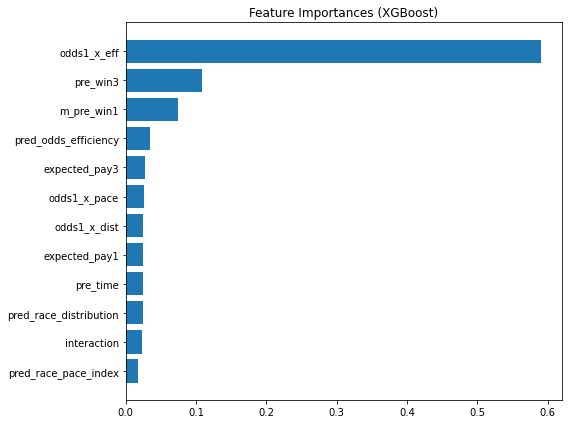

In [12]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt

# ---------------------------
# 1. 学習データの読み込み・前処理
# ---------------------------
# track_code = 3（例：ダートなど）を除外
df = df[df["track_code"] != 3].copy()

# 目的変数の作成
df_cali["target"] = (df_cali["pay1_r"] + df_cali["pay3_r"]) / 2.0
df_cali["log_target"] = np.log1p(df_cali["target"])
df_cali["exp_value"] = df_cali["m_pre_win1"] * df_cali["pre_odds1"]

# ---------------------------
# 2. 特徴量の作成・変換・交互作用項
# ---------------------------
df_cali["log_pre_odds1"] = np.log1p(df_cali["pre_odds1"])
df_cali["m_pre_win1_sq"] = df_cali["m_pre_win1"] ** 2
df_cali["interaction"] = df_cali["m_pre_win1"] * df_cali["pre_odds1"]

# pre_odds1との交互作用項
df_cali["odds1_x_dist"] = df_cali["pre_odds1"] * df_cali["pred_race_distribution"]
df_cali["odds1_x_eff"] = df_cali["pre_odds1"] * df_cali["pred_odds_efficiency"]
df_cali["odds1_x_pace"] = df_cali["pre_odds1"] * df_cali["pred_race_pace_index"]

# pre_odds1は除き、派生特徴量のみを活用
feature_cols = [
    "m_pre_win1",
    "pre_time",
    "interaction",
    "pre_win3",
    "expected_pay1",
    "expected_pay3",
    "pred_race_distribution",
    "pred_odds_efficiency",
    "pred_race_pace_index",
    "odds1_x_dist",
    "odds1_x_eff",
    "odds1_x_pace",
]

X = df_cali[feature_cols].copy()
y = df_cali["log_target"].copy()

# ---------------------------
# 3. 学習データの分割
# ---------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------
# 4. モデル + ハイパーパラメータ探索
# ---------------------------
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

def rmse_score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

xgb_base = XGBRegressor(random_state=42)

cv = KFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring=rmse_scorer,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)

best_model = random_search.best_estimator_

# ---------------------------
# 5. 予測とスケーリング
# ---------------------------
df_cali["log_pred"] = best_model.predict(X[feature_cols])
df_cali["pred_raw"] = np.expm1(df_cali["log_pred"])

mean_raw = df_cali["pred_raw"].mean()
scale_factor = 0.8 / mean_raw

df_cali["m_exp_value"] = df_cali["pred_raw"] * scale_factor

print(f"学習データ内の予測平均(補正前) = {mean_raw:.3f}")
print(f"学習データ内の予測平均(補正後) = {df_cali['m_exp_value'].mean():.3f}")

# ---------------------------
# 6. 特徴量重要度の可視化（横棒グラフ）
# ---------------------------
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.title("Feature Importances (XGBoost)")
plt.barh(range(len(feature_cols)), importances[indices], align="center")
plt.yticks(range(len(feature_cols)), [feature_cols[i] for i in indices])
plt.tight_layout()
plt.show()

# ---------------------------
# 7. 将来データへの適用
# ---------------------------
# 学習時と同様の特徴量生成を行う
df["log_pre_odds1"] = np.log1p(df["pre_odds1"])
df["m_pre_win1_sq"] = df["m_pre_win1"] ** 2
df["interaction"] = df["m_pre_win1"] * df["pre_odds1"]
df["odds1_x_dist"] = df["pre_odds1"] * df["pred_race_distribution"]
df["odds1_x_eff"] = df["pre_odds1"] * df["pred_odds_efficiency"]
df["odds1_x_pace"] = df["pre_odds1"] * df["pred_race_pace_index"]

X_test = df[feature_cols].copy()

df["log_pred"] = best_model.predict(X_test)
df["pred_raw"] = np.expm1(df["log_pred"])
df["m_exp_value"] = df["pred_raw"] * scale_factor


In [13]:
df["win1"].describe()

# test_exp_value を値に基づいて20のグループに分けるdf["rank_m_exp_value"] = pd.qcut(df["m_exp_value"], q=20, labels=False, duplicates='drop')
df["rank_m_exp_value"] = pd.qcut(df["m_exp_value"], q=18, labels=False, duplicates='drop')
# test_exp_value_group ごとの各値の平均値を表示
df.groupby("rank_m_exp_value").mean()[[ "odds_win1", "win1", "win3", "pay1_r", "pay3_r", "m_exp_value"]].round(3)[:20]

C:\Users\sekik\AppData\Local\Temp/ipykernel_67240/2645699432.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("rank_m_exp_value").mean()[[ "odds_win1", "win1", "win3", "pay1_r", "pay3_r", "m_exp_value"]].round(3)[:20]


,odds_win1,win1,win3,pay1_r,pay3_r,m_exp_value
rank_m_exp_value,,,,,,
0,NaN,0.0,0.0,0.0,0.0,0.123
1,NaN,0.0,0.0,0.0,0.0,0.235
2,NaN,0.0,0.0,0.0,0.0,0.294
3,NaN,0.0,0.0,0.0,0.0,0.343
4,NaN,0.0,0.0,0.0,0.0,0.397
5,NaN,0.0,0.0,0.0,0.0,0.451
6,NaN,0.0,0.0,0.0,0.0,0.529
7,NaN,0.0,0.0,0.0,0.0,0.639
8,NaN,0.0,0.0,0.0,0.0,0.711


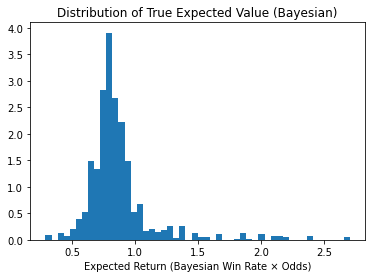

count    53549.000000
mean         0.870828
std          0.281854
min          0.290187
25%          0.744000
50%          0.812862
75%          0.909574
max          2.703448
Name: expected_return, dtype: float64


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. オッズビンを作成（1倍〜100倍まで、1刻み）
df_cali['odds_bin'] = pd.cut(df_cali['odds_win1'], bins=np.arange(1.0, 101.0, 1.0), include_lowest=True)

# 2. ベイズ勝率の集計
alpha, beta = 1, 1  # 事前分布（ベータ分布）

bin_stats = df_cali.groupby('odds_bin').agg(
    w=('win1', 'sum'),
    n=('win1', 'count')
).reset_index()

# ベイズ平滑化勝率
bin_stats['bayes_win_rate'] = (bin_stats['w'] + alpha) / (bin_stats['n'] + alpha + beta)

# ビンの中央値を参考として保持（オプション）
bin_stats['odds_bin_center'] = bin_stats['odds_bin'].apply(lambda x: x.mid)

# 3. df_cali に bayes_win_rate をマージ
df_cali = df_cali.merge(bin_stats[['odds_bin', 'bayes_win_rate']], on='odds_bin', how='left')

# 4. 期待値の計算
df_cali['expected_return'] = df_cali['bayes_win_rate'] * df_cali['odds_win1']

# 5. 可視化（ヒストグラム）
plt.hist(df_cali['expected_return'], bins=50, density=True)
plt.xlabel('Expected Return (Bayesian Win Rate × Odds)')
plt.title('Distribution of True Expected Value (Bayesian)')
plt.show()

# 6. 統計量の確認
print(df_cali['expected_return'].describe())


In [15]:
## Prediction 


import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 変数名（スペル注意）
columns = ['m_pre_win1', 'pre_win3', 'pre_time', 'expected_pay1', 'expected_pay3', 'pre_odds1']

# 欠損値除去
X = df[columns].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCAの実行
pca = PCA(n_components=len(columns))
X_pca = pca.fit_transform(X_scaled)

# 寄与率と累積寄与率
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print("=== 主成分の寄与率（Explained Variance Ratio） ===")
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1}: 寄与率 = {ev:.4f}, 累積 = {cv:.4f}")

# 主成分負荷量（各元変数が各主成分にどれだけ寄与しているか）
loadings = pd.DataFrame(pca.components_.T,
                        columns=[f'PC{i+1}' for i in range(len(columns))],
                        index=columns)

print("\n=== 主成分負荷量（Loadings） ===")
print(loadings.round(4))

# 主成分得点（各観測値の主成分空間での座標）
scores = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(len(columns))])
print("\n=== 主成分得点（Scores）の一部 ===")
print(scores.head())

# 必要なら、元のdfと合体
df["general_index"] = scores["PC1"]



## 回収率重視指標-----------------------------------------------------

## 的中率重視指標 ----------------------------------------------------

## 総合指標---------------------------------------------------------


=== 主成分の寄与率（Explained Variance Ratio） ===
PC1: 寄与率 = 0.6035, 累積 = 0.6035
PC2: 寄与率 = 0.1568, 累積 = 0.7604
PC3: 寄与率 = 0.1346, 累積 = 0.8950
PC4: 寄与率 = 0.0635, 累積 = 0.9585
PC5: 寄与率 = 0.0293, 累積 = 0.9878
PC6: 寄与率 = 0.0122, 累積 = 1.0000

=== 主成分負荷量（Loadings） ===
                  PC1     PC2     PC3     PC4     PC5     PC6
m_pre_win1     0.4637  0.1648 -0.4222  0.1079 -0.2418  0.7138
pre_win3       0.4564  0.3598  0.1609 -0.2446 -0.6089 -0.4537
pre_time       0.3898 -0.0679  0.5434  0.7340  0.0965  0.0056
expected_pay1  0.4419  0.2120 -0.4594  0.0468  0.6183 -0.4052
expected_pay3 -0.2465  0.8598  0.2924 -0.0406  0.2492  0.2251
pre_odds1     -0.4108  0.2335 -0.4517  0.6212 -0.3421 -0.2641

=== 主成分得点（Scores）の一部 ===
        PC1       PC2       PC3       PC4       PC5       PC6
0 -1.707502 -0.621233 -0.744295 -0.222804  0.300322  0.114982
1 -1.412405 -1.046597  0.486222  0.970634 -0.166192  0.181211
2 -0.826842 -1.028291  0.445011  0.186540  0.171839  0.176628
3 -2.250938  0.079235  0.068370  1.536

In [17]:

### variables treatment 

## sign --------------------------------------------------
# 対象列リスト
x = ['m_exp_value', 'pre_time', 'general_train_index', "general_index"]
# 評価記号の辞書（1位〜5位）
rank_symbols = {1: '◎', 2: '〇', 3: '▲', 4: '△', 5: '✕'}
# 各列についてランク付け → 評価記号に変換（6位以降は空欄）
for col in x:
    # race_keyごとにランク付け
    df[f'{col}_rank'] = df.groupby('race_key')[col].rank(method='min', ascending=False).astype('Int64')
    
    # ランクに応じた記号を付ける
    df[f'{col}_mark'] = df[f'{col}_rank'].apply(
        lambda r: rank_symbols[r] if pd.notnull(r) and r in rank_symbols else '.'
    )

# 対象列リスト
x = ['pre_odds_win1']
# 評価記号の辞書（1位〜5位）
rank_symbols = {1: '◎', 2: '〇', 3: '▲', 4: '△', 5: '✕'}
# 各列についてランク付け → 評価記号に変換（6位以降は空欄）
for col in x:
    # race_keyごとにランク付け
    df[f'{col}_rank'] = df.groupby('race_key')[col].rank(method='min', ascending=True).astype('Int64')
    
    # ランクに応じた記号を付ける
    df[f'{col}_mark'] = df[f'{col}_rank'].apply(
        lambda r: rank_symbols[r] if pd.notnull(r) and r in rank_symbols else '.'
    )

## Standardize ------------------------------------------------
std_var = ["pre_time"]
# 平均100、標準偏差10の正規分布に変換
# 平均・標準偏差列を先に作る
for col in std_var:
    df[f'{col}_mean'] = df[col].mean()
    df[f'{col}_std'] = df[col].std()
# その後、それらを使って正規化
for col in std_var:
    mean_col = f'{col}_mean'
    std_col = f'{col}_std'
    df[f'std_{col}'] = ((df[col] - df[mean_col]) / df[std_col]) * 10 + 100

## レース内標準化
std_by_race = ["general_train_index", "general_index"]
# 欠損値をrace_keyごとに平均値で補完
df[std_by_race] = df.groupby("race_key")[std_by_race].transform(lambda x: x.fillna(x.mean()))


for col in std_by_race:
    df[f'{col}_mean'] = df[col].mean()
    df[f'{col}_std'] = df[col].std()
for col in std_by_race:
    def scale(x):
        std = x.std()
        return ((x - x.mean()) / std) * 10 + 100 if std != 0 else 100
    df[f'std_{col}'] = df.groupby('race_key')[col].transform(scale)

## レース毎の標準化
std_race_var = ["pred_race_distribution", "pred_odds_efficiency", "pred_race_pace_index"]
# まず、標準化に使う統計量（mean, std）をumaban==1のサンプルだけから計算
group_stats = df[df['umaban'] == 1].groupby('race_key')[std_race_var].agg(['mean', 'std'])
# 列名を揃えやすくするために列のMultiIndexをフラットに
group_stats.columns = [f'{col}_{stat}' for col, stat in group_stats.columns]
# 元のDataFrameに統計量をマージ（race_keyで結合）
df = df.merge(group_stats, on='race_key', how='left')
# 各列について標準化を適用
for col in std_race_var:
    df[f'{col}_mean'] = df[col].mean()
    df[f'{col}_std'] = df[col].std()
for col in std_race_var:
    mean_col = f'{col}_mean'
    std_col = f'{col}_std'
    df[f'std_{col}'] = ((df[col] - df[mean_col]) / df[std_col]) * 10 + 100


## 分類分け --------------------------------------------------
# 波乱度：std_pred_race_distributionを5分位に分ける(値が大きいグループに値を大きい数値を付与)
df["rank_race_distribution"] = pd.qcut(
    df["std_pred_race_distribution"],
    q=5,
    labels=[1, 2, 3, 4, 5]
).astype(int)

# レース推奨度
df["rank_race_recommendation"] = pd.qcut(
    df["std_pred_odds_efficiency"],
    q=5,
    labels=[1, 2, 3, 4, 5]
).astype(int)

# Pace Predictio
df["pre_pace"] = pd.qcut(
    df["std_pred_race_pace_index"],
    q=3,
    labels=[1, 2, 3]
).astype(int)

## 四捨五入 --------------------------------------------------
# 0
under0_list = ["pre_time", "std_pred_race_distribution", "std_pred_odds_efficiency", "std_pred_race_pace_index", "std_general_train_index"]
df[under0_list] = df[under0_list].round(0).astype(np.int64)
# 0.1
under1_list = ["pre_odds_win1", "std_general_index"]
df[under1_list] = df[under1_list].round(1).astype(np.float64)
# 0.01
under2_list = ["reliability"]
df[under2_list] = df[under2_list].round(2).astype(np.float64)
# 0.001
under3_list = ["m_exp_value", "m_pre_win1", "pre_win2" ,"pre_win3"]
df[under3_list] = df[under3_list].round(3).astype(np.float64)
# 特別な場合
df["m_exp_value"] = df["m_exp_value"].apply(lambda x: float(f"{x:.3f}"))

## transform --------------------------------------------------
# track_code
df["track_code"] = df["track_code"].map({1: "芝", 2: "ダート", 3: "障害"})
# gender_flag
df["gender_flag"] = df["gender_flag"].map({1: "牡", 2: "牝", 3: "セ"})
# race distribution
df["rank_race_distribution"] = df["rank_race_distribution"].map({1: "堅い", 2: "稍堅", 3: "稍荒", 4: "荒れ", 5: "大荒"})
# pre pace
df["pre_pace"] = df["pre_pace"].map({1: "スロー", 2: "ミドル", 3: "ハイ"})

## rename --------------------------------------------------
rename_val = {
    "pre_odds_win1_mark": "accuracy_focused_mark",
}
df = df.rename(columns=rename_val)

## drop --------------------------------------------------
df = df.dropna(subset=["horse_name"])

##

C:\Users\sekik\AppData\Local\Temp/ipykernel_67240/1489180388.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_mean'] = df[col].mean()
C:\Users\sekik\AppData\Local\Temp/ipykernel_67240/1489180388.py:71: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_std'] = df[col].std()
C:\Users\sekik\AppData\Local\Temp/ipykernel_67240/1489180388.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

## Save Data


In [20]:
### Save

### final_data_sets
final_basic_list = ["key", "date_key", "race_key", "kaizi", "nitizi", "place_name", "track_code", "dist", "class_name", "race_type", "race_weight", "all_race_name", "num_horse", "R", "umaban", "horse_name", "jockey_name", "trainer_name", "m_leg_type", "age", "gender_flag" ]
final_mark_list = ["general_index_mark", "m_exp_value_mark", "accuracy_focused_mark", "pre_time_mark", 'general_train_index_mark']
final_index_list = ["pre_odds_win1", "m_exp_value", "std_general_index", "m_pre_win1", "pre_win2", "pre_win3", "pre_time", 'std_general_train_index', "reliability", 'rank_race_distribution', 'rank_race_recommendation', 'pre_pace', "std_pred_race_distribution", "std_pred_odds_efficiency", "std_pred_race_pace_index"]


df_final = df[[col for col in final_basic_list + final_mark_list + final_index_list if col in df.columns]]
df_final = df_final.sort_values(by=["date_key", "race_key", "umaban"])

### rename to Japanese variable name
# 変換マップ（英語 → 日本語）
rename_dict = {
    ## 基本情報
    'key': 'キー',
    'date_key': '日付',
    'race_key' : 'レースキー',
    'kaizi': '回次',
    'nitizi': '日次',
    'place_name': '場所',
    'track_code': 'トラック',
    'dist': '距離',
    'class_name': 'クラス',
    'race_type': 'レース種別',
    'race_weight': 'レース重量',
    'all_race_name': 'レース名',
    'num_horse': '頭数',
    'R': 'R',
    'umaban': '馬番',
    'horse_name': '馬名',
    'jockey_name': '騎手名',
    'trainer_name': '調教師名',
    'm_leg_type': '脚質',
    'age': '馬齢',
    'gender_flag': '性別',
    # 予想印
    "general_index_mark": "総合印",
    "m_exp_value_mark": "回収率印", 
    "accuracy_focused_mark": "的中率印",
    "pre_time_mark": "タイム印",
    "general_train_index_mark": "追切調教",
    # 予想指数：馬
    'pre_odds_win1': '予想単オッズ',
    'm_exp_value': '期待値',
    'std_general_index': '総合指数',
    'm_pre_win1': '予想単勝率',
    'pre_win2': '予想連対率',
    'pre_win3': '予想複勝率',
    'pre_time': '予想タイム',
    'std_general_train_index': '調教追切指数',
    "reliability": '予想信頼度',
    # レース指数
    'rank_race_distribution': '波乱度',
    'rank_race_recommendation': 'レース推奨度',
    'pre_pace': '予想ペース',
    "std_pred_race_distribution": "波乱度指数",
    "std_pred_odds_efficiency": "R推奨度指数", 
    "std_pred_race_pace_index": "Rペース指数",
    
}

# 列名の変換
df_jp = df_final.rename(columns=rename_dict)


'''
### save
## to dta
df.to_stata(export_path + "final_data_sets.dta", write_index=False, version=117, index=False)

## to excel
df_to_excel.to_excel(export_path + "final_data_sets.xlsx", index=False, engine="openpyxl")


'''




'\n### save\n## to dta\ndf.to_stata(export_path + "final_data_sets.dta", write_index=False, version=117, index=False)\n\n## to excel\ndf_to_excel.to_excel(export_path + "final_data_sets.xlsx", index=False, engine="openpyxl")\n\n\n'

In [21]:
# float64 の中でも実質整数のようなカラムを変換する
for col in df_final.select_dtypes(include="float64").columns:
    if (df_final[col].dropna() % 1 == 0).all():
        df_final[col] = df_final[col].astype("Int64")


In [22]:
from google.cloud import bigquery
import pandas as pd
import os
import pyarrow

# ---------------------------
# 設定項目（適宜変更してください）
# ---------------------------
project_id = "keiba-database"      # GCP プロジェクトID
dataset_id = "predict_datasets"      # 使用するデータセットID
table_id   = "predict_record_var4"      # 本番テーブルの名前
destination_table = f"{project_id}.{dataset_id}.{table_id}"
staging_table = f"{project_id}.{dataset_id}.{table_id}_staging"

# ---------------------------
# BigQuery クライアントの作成
# ---------------------------
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"D:\\Dropbox\\11_Amusement\\10_Horse_Racing\\11_Database\\JRDB\\keiba-database-94563ca3545b.json"
client = bigquery.Client(project=project_id)

# ---------------------------
# ステージングテーブルに df_final をロード（常に上書き）
# ---------------------------
job_config = bigquery.LoadJobConfig(
    autodetect=True,  # DataFrame のスキーマを自動検出
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE  # 毎回上書き
)

load_job = client.load_table_from_dataframe(df_final, staging_table, job_config=job_config)
load_job.result()  # ジョブの完了を待機
print("ステージングテーブルにデータをロードしました。")

# ---------------------------
# 本番テーブルの存在チェック
# ---------------------------
try:
    dest_table = client.get_table(destination_table)
    table_exists = True
    print("本番テーブルは存在します。")
except Exception as e:
    table_exists = False
    print("本番テーブルは存在しないため、これから作成します。")

if not table_exists:
    # 本番テーブルが存在しない場合は、ステージングテーブルをコピーして作成
    copy_job = client.copy_table(staging_table, destination_table)
    copy_job.result()
    print("本番テーブルをステージングテーブルから作成しました。")
else:
    # 本番テーブルが存在する場合、欠損しているカラムがあれば追加する処理

    # 既存テーブルとステージングテーブルのカラム名を取得
    dest_table = client.get_table(destination_table)
    dest_columns = {field.name for field in dest_table.schema}

    staging_table_obj = client.get_table(staging_table)
    staging_columns = {field.name for field in staging_table_obj.schema}

    # 既存テーブルに無いカラムを抽出
    missing_cols = staging_columns - dest_columns

    # 型名を BigQuery 対応にマッピングする関数
    def normalize_bq_type(field_type):
        type_map = {
            "FLOAT": "FLOAT64",
            "INTEGER": "INT64",
            "BOOLEAN": "BOOL",
            "STRING": "STRING",
            "TIMESTAMP": "TIMESTAMP",
            "DATE": "DATE",
            "DATETIME": "DATETIME"
        }
        return type_map.get(field_type.upper(), field_type.upper())  # fallbackあり

    # 欠損カラムの追加処理（修正版）
    if missing_cols:
        for col in missing_cols:
            field = next((f for f in staging_table_obj.schema if f.name == col), None)
            if field:
                field_type_bq = normalize_bq_type(field.field_type)
                alter_query = f"""
                ALTER TABLE `{destination_table}`
                ADD COLUMN {col} {field_type_bq}
                """
                query_job = client.query(alter_query)
                query_job.result()
                print(f"カラム {col} ({field_type_bq}) を追加しました。")

    # MERGE 文で本番テーブルとステージングテーブルを統合
    staging_columns = list(df_final.columns)

    merge_query = f"""
    MERGE `{destination_table}` T
    USING `{staging_table}` S
    ON T.key = S.key
    WHEN MATCHED THEN
      UPDATE SET {', '.join([f"T.{col}=S.{col}" for col in staging_columns])}
    WHEN NOT MATCHED THEN
      INSERT ({', '.join(staging_columns)})
      VALUES ({', '.join([f"S.{col}" for col in staging_columns])})
    """

    merge_job = client.query(merge_query)
    merge_job.result()
    print("ステージングテーブルのデータを本番テーブルにマージ（重複更新・新規挿入）しました。")

# ---------------------------
# df_final に基づく列順のビューを作成
# ---------------------------
view_name_order = "predict_record_order_var4"
create_view_query_final = f"""
CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.{view_name_order}` AS
SELECT {', '.join(df_final.columns)}
FROM `{destination_table}`
"""
client.query(create_view_query_final).result()
print(f"ビュー {view_name_order} を作成しました（df_finalの列順）。")

# ---------------------------
# df_jp テーブルとビューの作成
# ---------------------------
table_id_jp = "predict_record_jp_var4"
destination_table_jp = f"{project_id}.{dataset_id}.{table_id_jp}"
view_name_order_jp = "predict_record_jp_order_var4"

# テーブル書き込み
job_config_jp = bigquery.LoadJobConfig(
    autodetect=True,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)
load_job_jp = client.load_table_from_dataframe(df_jp, destination_table_jp, job_config=job_config_jp)
load_job_jp.result()
print("日本語テーブル（predict_record_jp_var4）を作成・上書きしました。")

# SELECT 文用カラム名：すべてバッククォートで囲む（←重要）
quoted_columns = ', '.join([f'`{col}`' for col in df_jp.columns])

# ビュー作成クエリ
create_view_query_jp = f"""
CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.{view_name_order_jp}` AS
SELECT {quoted_columns}
FROM `{destination_table_jp}`
"""

# 実行
client.query(create_view_query_jp).result()
print(f"ビュー {view_name_order_jp} を作成しました（df_jpの列順）。")

c:\Users\sekik\anaconda3\lib\site-packages\google\cloud\bigquery\_pandas_helpers.py:489: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(
c:\Users\sekik\anaconda3\lib\site-packages\google\cloud\bigquery\_pandas_helpers.py:628: UserWarning: Pyarrow could not determine the type of columns: class_name, race_type, race_weight, m_leg_type.
  warnings.warn(


ステージングテーブルにデータをロードしました。
本番テーブルは存在します。
カラム reliability (FLOAT64) を追加しました。
ステージングテーブルのデータを本番テーブルにマージ（重複更新・新規挿入）しました。
ビュー predict_record_order_var4 を作成しました（df_finalの列順）。


c:\Users\sekik\anaconda3\lib\site-packages\google\cloud\bigquery\_pandas_helpers.py:489: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(
c:\Users\sekik\anaconda3\lib\site-packages\google\cloud\bigquery\_pandas_helpers.py:628: UserWarning: Pyarrow could not determine the type of columns: クラス, レース種別, レース重量, 脚質.
  warnings.warn(


日本語テーブル（predict_record_jp_var4）を作成・上書きしました。
ビュー predict_record_jp_order_var4 を作成しました（df_jpの列順）。


In [ ]:
df_final["reliability"]

461    2.88
437   -1.86
488    3.26
500    3.58
364    0.20
       ... 
348   -5.88
296   -5.45
316    1.03
259    3.74
328    3.05
Name: reliability, Length: 505, dtype: float64

: 